In [75]:
import numpy as np 
import pandas as pd 
import sklearn as sk 
import matplotlib.pyplot as plt
from typing import Tuple
import glob
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, random_split, DataLoader
import torch.optim as optim

#moved everything out
from utils import visualize, percent_healthy, get_glucose_response, discretize
import constants

In [76]:
MACROS = ["Calories", "Carbs", "Protein", "Fiber", "Fat"]
FACTORS = ["BMI", "A1c PDL (Lab)", "Fasting GLU - PDL (Lab)", "Insulin "]

In [77]:
def get_subject_no(file_path: Path) -> int:
    components = Path(file_path).parts
    subj = components[3][-3:]
    return int(subj)

In [78]:
##load everything in 
physio = pd.read_csv(r"../../CGMacros/bio.csv", index_col="subject") #reindex
paths = glob.glob(r"../../CGMacros/CGMacros-*/CGMacros-*.csv", recursive=True)
df = pd.read_csv(paths[0]).fillna(0)


In [79]:
df


,Timestamp,Libre GL,Dexcom GL,HR,Calories (Activity),METs,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed,Image path
0,2023-05-09 09:01:00,179.000000,0.0,0.0,1.1323,10.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2023-05-09 09:02:00,179.733333,0.0,0.0,1.1323,10.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2023-05-09 09:03:00,180.466667,0.0,0.0,1.1323,10.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2023-05-09 09:04:00,181.200000,0.0,0.0,1.1323,10.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2023-05-09 09:05:00,181.933333,0.0,67.0,1.1323,10.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17245,2023-05-21 08:26:00,107.000000,0.0,0.0,0.0000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
17246,2023-05-21 08:27:00,106.800000,0.0,0.0,0.0000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
17247,2023-05-21 08:28:00,106.600000,0.0,0.0,0.0000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
17248,2023-05-21 08:29:00,106.400000,0.0,0.0,0.0000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [80]:
physio

,Age,Gender,BMI,Body weight,Height,Self-identify,A1c PDL (Lab),Fasting GLU - PDL (Lab),Insulin,Triglycerides,...,LDL (Cal),VLDL (Cal),Cho/HDL Ratio,Collection time PDL (Lab),#1 Contour Fingerstick GLU,Time (t),#2 Contour Fingerstick GLU,Time (t).1,#3 Contour Fingerstick GLU,Time (t).2
subject,,,,,,,,,,,,,,,,,,,,,
1,27,M,22.265239,133.8,65.00,Hispanic/Latino,5.4,91,2.5,67,...,130,13,2.9,11:06:00 AM,89,9:40,73,12:11,81,13:18
2,49,F,30.946742,169.2,62.00,Hispanic/Latino,5.5,93,14.8,61,...,78,12,2.0,7:38:00 AM,91,7:52,123,9:21,80,10:22
3,59,F,26.948690,157.0,64.00,Hispanic/Latino,6.5,118,17.4,154,...,90,31,2.6,7:25:00 AM,119,7:38,166,9:23,98,10:23
4,33,F,42.384279,262.6,66.00,Hispanic/Latino,5.5,105,19.4,300,...,164,60,5.8,7:20:00 AM,109,7:37,110,9:04,90,10:01
5,51,F,30.957534,172.0,62.50,Hispanic/Latino,6.6,144,12.9,392,...,157,78,7.1,7:45:00 AM,139,8:59,215,10:52,130,11:54
6,51,F,29.303451,197.0,68.75,White,5.2,96,6.4,75,...,118,15,2.8,7:45:00 AM,98,9:04,97,10:54,70,11:56
7,66,F,27.070327,199.6,72.00,Hispanic/Latino,5.9,108,15.9,92,...,67,18,3.0,8:00:00 AM,115,8:40,157,10:22,95,11:24
8,54,M,39.945440,218.4,62.00,Hispanic/Latino,5.8,112,17.7,145,...,95,29,3.0,8:55:00 AM,110,9:07,156,10:25,94,11:26
9,34,F,37.001506,183.2,59.00,Hispanic/Latino,5.7,122,25.7,312,...,108,62,5.1,7:32:00 AM,119,7:46,128,9:32,96,10:29


In [81]:
li = physio[FACTORS].iloc[9,:].values
[li] * 5

[array([ 35.81189162,   5.7       , 100.        ,  15.3       ]),
 array([ 35.81189162,   5.7       , 100.        ,  15.3       ]),
 array([ 35.81189162,   5.7       , 100.        ,  15.3       ]),
 array([ 35.81189162,   5.7       , 100.        ,  15.3       ]),
 array([ 35.81189162,   5.7       , 100.        ,  15.3       ])]

In [102]:
#get glucose response for all participants
mldf = pd.DataFrame([])
for path in paths:
    #glucose reponse
    df = pd.read_csv(path).fillna(0)    
    ml = get_glucose_response(df, unhealthy=False, discrete=False)
    subj = get_subject_no(path)
    
    try:
        biomarkers = list(physio[FACTORS].iloc[subj-1,:])
    except: #some subjects are missing from physio
        biomarkers = [None] * len(FACTORS)
    
    biomarkers_df = pd.DataFrame([biomarkers] * len(ml))
    biomarkers_df.columns = FACTORS
    subj_params = pd.concat([ml.reset_index(drop=True), biomarkers_df.reset_index(drop=True)], axis = 1)
    mldf = pd.concat([mldf, subj_params], axis = 0)

mldf = mldf.reset_index(drop=True)
mldf = mldf.dropna(subset=FACTORS)

In [103]:
lib = mldf["lib_prom"]
dex = mldf["dex_prom"]

np.corrcoef(lib, dex)

array([[1.        , 0.73552142],
       [0.73552142, 1.        ]])

In [104]:
#create new combined dataset
LEN_OBS = len(mldf)
dev = np.zeros(LEN_OBS*2)
dev[LEN_OBS:] = 1  #device indicator (0: lib, 1: dex)

mldf_combined = pd.concat([mldf, mldf])
mldf_combined["dev"] = dev #adding new variable
response_combined = pd.concat([mldf["lib_prom"], mldf["dex_prom"]])

In [105]:
class SpikeDataset(Dataset):
    def __init__(self, macros, spike):
        self.macros = macros.reset_index(drop=True) #vector of macro values (carbs, protein, fiber, fats, calories)
        self.spike = spike.reset_index(drop=True) #R1 collected spike value (mg/dL)
    
    def __len__(self):
        return len(self.spike)
    
    def __getitem__(self, idx):
        meal = torch.tensor(self.macros.iloc[idx, :], dtype = torch.float32) #wrap in tensors
        response = torch.tensor([self.spike[idx]], dtype = torch.float32) #expects 1d, not scalar 
        return meal, response #X, y

#make two different datasets for libre and dexcome data
SD_lib = SpikeDataset(mldf[MACROS+FACTORS], mldf["lib_prom"])
SD_dex = SpikeDataset(mldf[MACROS+FACTORS], mldf["dex_prom"])
SD = SpikeDataset(mldf_combined[MACROS+FACTORS], response_combined)


In [112]:
#split cwt_data (Dataset) into 80 20 train/test split
data_len = len(SD)

train_size = int(0.8 * data_len)
val_size = int(0.1 * data_len)
test_size = data_len - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(SD, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle = True)
validation_loader = DataLoader(val_dataset, batch_size=64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle = False)

In [113]:
#K.I.S.S!
class MacroNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.l1 = nn.Linear(9, 100) #5 macros
        self.l2 = nn.Linear(100, 50)
        self.l3 = nn.Linear(50, 16)
        self.l4 = nn.Linear(16, 1) #regression, use raw logit
        
    
    def forward(self, x): #define forward pass i.e. how does the model handle inputs?
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        
        return x

model = MacroNN()


In [114]:
#define additional hyperparameters
#loss = nn.MSELoss()
loss = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_track = []
val_track = []

EPOCHS = 500 
for epoch in range(EPOCHS):
    
    total_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        X, y = data
        optimizer.zero_grad() #zero out gradients so weights aren't misadjusted
        
        out = model(X)
        loss_val = loss(out, y) #MSE loss calculated with output and y 
        
        loss_val.backward() #backpropataion
        optimizer.step() #adjust weights based on backpropagation
        
        total_loss += loss_val.item()
        #print(f"loss: {loss_val.item()}")
        
    loss_track.append(total_loss / len(train_loader)) #avg training loss /epoch
    
    total_val_loss = 0.0
    
    with torch.no_grad():
        model.eval() #set to evaluation mode
        for Xv, yv in validation_loader:
            ypr = model(Xv)
            val_loss = loss(ypr, yv).item()
            total_val_loss += val_loss
        
        val_track.append(total_val_loss / len(validation_loader)) #avg val loss
        model.train()
        
print("finished training")

finished training


note Huber loss is quadratic close to 0, and absval/linear away from zero --> less sensitive to outliers

In [115]:
from sklearn.metrics import r2_score, mean_squared_error

model.eval()  # set to eval mode

all_preds = []
all_truths = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        preds = model(X_test)
        all_preds.append(preds.squeeze().cpu())   # flatten and move to CPU
        all_truths.append(y_test.squeeze().cpu())

# Convert to flat NumPy arrays
import torch
y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_truths).numpy()

# Metrics
print("MSE:", mean_squared_error(y_true, y_pred))
print("R²:", r2_score(y_true, y_pred))

MSE: 3230.424
R²: 0.16788208484649658


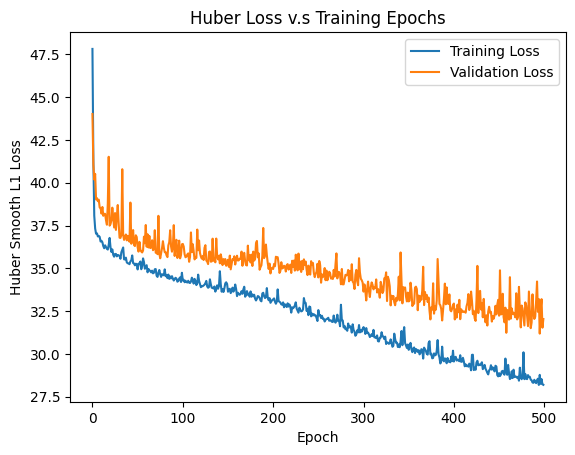

In [116]:
plt.plot(loss_track, label = "Training Loss")
plt.plot(val_track, label = "Validation Loss")
plt.title("Huber Loss v.s Training Epochs")
plt.xlabel("Epoch")
plt.ylabel("Huber Smooth L1 Loss")
plt.legend()


In [117]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae:.2f} mg/dL")

MAE: 38.34 mg/dL
